# Regresión logisitca

En este notebook se experimenta con varios modelos de regresión logística usando el dataset proporcionado por Jaime. Se trata de optimizar los modelos a través de GridSearch, BayesSearch y Optuna, considerando combinaciones útiles de parámetros. 

Primero, se importan las librerías usadas, los datos preprocesados y se construye una función para evaluar los modelos obtenidos.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import graphviz
import joblib
import optuna
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
X_train = pd.read_csv("../Data/Prueba_Jaime/preprocessed_train_dataset.csv", index_col="respondent_id")
X_test = pd.read_csv("../Data/Prueba_Jaime/preprocessed_test_dataset.csv", index_col="respondent_id")
y_train = pd.read_csv("../Data/Prueba_Jaime/labels_train_dataset.csv", index_col="respondent_id")
y_test =  pd.read_csv("../Data/Prueba_Jaime/labels_test_dataset.csv", index_col="respondent_id")

In [5]:
def evaluate_model(best_model, X_train, y_train):
    y_pred_proba = best_model.predict_proba(X_train)
    y_pred = best_model.predict(X_train)

    # Calcular ROC AUC para cada label
    roc_auc_scores = [
        roc_auc_score(y_train.iloc[:, i], y_pred_proba[i][:, 1]) for i in range(y_train.shape[1])
    ]

    # Calcular Accuracy para cada label
    accuracy_scores = [
        accuracy_score(y_train.iloc[:, i], y_pred_proba[i].argmax(axis=1)) for i in range(y_train.shape[1])
    ]

    print("Primeras 5 probabilidades para label 0:", y_pred_proba[0][:5, 1])
    print("Primeras 5 probabilidades para label 1:", y_pred_proba[1][:5, 1], "\n")

    print(f"ROC AUC global: {roc_auc_score(y_train, y_pred)}")
    print("Accuracy global:", accuracy_score(y_train, y_pred))
    print("ROC AUC Scores de cada label:", roc_auc_scores)
    print("Accuracy Scores de cada label:", accuracy_scores, "\n")
    print("Reporte de Clasificación:")
    print(classification_report(y_train, y_pred, zero_division=0))
    
    return "-----------------------------------------------------------------------------------"


# Modelo sin regularización, con GridSearch y balanceo


Empezamos probando la regresión logística sin regularización. Unos solvers adecuados para modelos de regresión logística que no emplean la regularización son 'saga' y 'lbfgs'. Se aplica validación cruzada con 5 particiones, usando como métrica principal roc_auc, y visualizando igualmente accuracy.  El balanceo se usa para gestionar el desequilibrio de clases, sabiendo que la mayoría no se vacuna.

In [3]:
# Con balanceo
# Envolver modelo de regresion en MultiOutputClassifier
logistic_regression_multilabel = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, class_weight='balanced')
)

# Ajustar parámetros Grid Search para MultiOutputClassifier (sin regularización)
param_grid = {
    'estimator__solver': ['saga', 'lbfgs'],  # Compatible con penalty='none'
    'estimator__penalty': [None],  # Sin regularización
    'estimator__max_iter': [500, 1000, 2000],  
    'estimator__fit_intercept': [True, False],  
    'estimator__tol': [1e-3, 1e-4, 1e-5]  
}

# Grid Search
grid_search = GridSearchCV(
    estimator=logistic_regression_multilabel,
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 particiones
    scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc_ovr'},  # Métricas
    refit='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Guardar resultados
results = pd.DataFrame(grid_search.cv_results_)
columns = [
    'mean_test_accuracy', 
    'mean_test_roc_auc', 
    'param_estimator__solver', 
    'param_estimator__penalty', 
    'param_estimator__max_iter', 
    'param_estimator__tol',
    'param_estimator__fit_intercept'
]

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(grid_search.best_estimator_, "../Modelos/Prueba_Jaime/LogisticRegression_gridsearch_none.pkl")
print("Modelo guardado como 'LogisticRegression_gridsearch_none.pkl'")

# Guardar y ordenar resultados
results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Jaime/logistic_gridsearch_none_results_table.csv', index=False)
results_table.sort_values(by=['mean_test_roc_auc', 'mean_test_accuracy'], ascending=[False, False]).head(5)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'estimator__fit_intercept': True, 'estimator__max_iter': 500, 'estimator__penalty': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.001}
Modelo guardado como 'LogisticRegression_gridsearch_none.pkl'


,mean_test_accuracy,mean_test_roc_auc,param_estimator__solver,param_estimator__penalty,param_estimator__max_iter,param_estimator__tol,param_estimator__fit_intercept
3,0.644245,0.858308,lbfgs,None,500,0.0010,True
9,0.644245,0.858308,lbfgs,None,1000,0.0010,True
15,0.644245,0.858308,lbfgs,None,2000,0.0010,True
4,0.643859,0.858146,lbfgs,None,500,0.0001,True
10,0.643859,0.858146,lbfgs,None,1000,0.0001,True


El mejor modelo según el GridSearch ofrece en training un ROC AUC global: 0.7859226038886156 y Accuracy global: 0.6497902502531463. Los resultados son mejores cuando se consideran las métricas a nivel de cada etiqueta: 
* ROC AUC Scores de cada label: [0.8656031753862355, 0.8584886840384179]
* Accuracy Scores de cada label: [0.797483003037755, 0.7831621582525676] 

In [74]:
best_model = joblib.load("../Modelos/Prueba_Jaime/LogisticRegression_gridsearch_none.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test, y_test))

TRAIN:
Primeras 5 probabilidades para label 0: [0.47519863 0.58031765 0.07361827 0.21621886 0.37860485]
Primeras 5 probabilidades para label 1: [0.73852132 0.51517872 0.77842233 0.12144595 0.53271595] 

ROC AUC global: 0.7859226038886156
Accuracy global: 0.6497902502531463
ROC AUC Scores de cada label: [0.8656031753862355, 0.8584886840384179]
Accuracy Scores de cada label: [0.797483003037755, 0.7831621582525676] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      4433
           1       0.76      0.78      0.77      9718

   micro avg       0.67      0.78      0.72     14151
   macro avg       0.64      0.78      0.70     14151
weighted avg       0.69      0.78      0.72     14151
 samples avg       0.36      0.38      0.36     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilidades para label 0: [0.04268559 0.78337168 0.21061221 0.34418274 

# Modelo con regularización l1, l2, con Grid Search

La regularización LASSO podría ser de gran interés, ya que permite descartar variables.Liblinear y saga son solvers que aceptan como penalización 'l1'(LASSO) y, además, 'l2'(RIDGE), por lo cual los vamos a emplear. 

Igualmente, se quiere observar si el balanceo produce cambios en los resultados, dado que la clase 1 es minoritaria en ambas etiquetas. Los resultados sin balanceo indican una mayor accuracy en cuanto al label 0. Esto ocurre porque al no aplicar el balanceo más instancias de la clase mayoritaria 0 llegan a formar el conjunto de training, y por tal al predecir 0 se acierta en más casos. Nosotros no queremos caer en esta trampa, por lo cual vamos a emplear siempre el procedimiento que balancea las clases antes de entrenar.

# Sin Balanceo

In [5]:
# Sin balanceo
# Envolver modelo de regresion en MultiOutputClassifier
logistic_regression_multilabel =  MultiOutputClassifier(LogisticRegression(max_iter=1000))

# Adjustar parametros Grid Search para MultiOutputClassifier  #'liblinear', 'saga'
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000],  
    'estimator__penalty': ['l1', 'l2'],            
    'estimator__solver': ['liblinear', 'saga'],   
    'estimator__max_iter': [100, 1000]            
}

# Grid Search
grid_search = GridSearchCV(
    estimator=logistic_regression_multilabel,
    param_grid=param_grid,
    cv=5,  
    scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}, 
    refit='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)


# Guardar resultados
results = pd.DataFrame(grid_search.cv_results_)
columns = [
    'mean_test_accuracy', 
    'mean_test_roc_auc', 
    'param_estimator__C', 
    'param_estimator__penalty', 
    'param_estimator__solver', 
    'param_estimator__max_iter'
]

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(grid_search.best_estimator_, "../Modelos/Prueba_Jaime/LogisitcRegression_gridsearch_unbalanced.pkl")
print("Modelo guardado como 'LogisitcRegression_gridsearch_unbalanced.pkl'")

results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Jaime/logistic_gridsearch_unbalanced_results_table.csv', index=False)
results_table.sort_values(by=['mean_test_roc_auc', 'mean_test_accuracy'], ascending=[False, False]).head(5)


Fitting 5 folds for each of 48 candidates, totalling 240 fits


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Mejores hiperparámetros: {'estimator__C': 0.1, 'estimator__max_iter': 100, 'estimator__penalty': 'l2', 'estimator__solver': 'saga'}
Modelo guardado como 'LogisitcRegression_gridsearch_unbalanced.pkl'


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,mean_test_accuracy,mean_test_roc_auc,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_estimator__max_iter
11,0.682627,0.858447,0.1,l2,saga,100
15,0.682434,0.858441,0.1,l2,saga,1000
21,0.682386,0.858431,1.0,l1,saga,1000
17,0.682579,0.858429,1.0,l1,saga,100
16,0.682530,0.858420,1.0,l1,liblinear,100


In [25]:
best_model = joblib.load("../Modelos/Prueba_Jaime/LogisitcRegression_gridsearch_unbalanced.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.20966508 0.24210835 0.02229487 0.07344453 0.14423392]
Primeras 5 probabilities para label 1: [0.71536291 0.50607686 0.76045411 0.11219593 0.50252397] 

ROC AUC global: 0.7532878501244837
Accuracy global: 0.6857129080476397
ROC AUC Scores de cada label: [0.8648592676122617, 0.8584739504307284]
Accuracy Scores de cada label: [0.8538984521915233, 0.7847051448960894] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.73      0.50      0.59      4433
           1       0.78      0.75      0.77      9718

   micro avg       0.77      0.67      0.72     14151
   macro avg       0.76      0.63      0.68     14151
weighted avg       0.77      0.67      0.71     14151
 samples avg       0.36      0.34      0.34     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.0117084  0.49561572 0.07456555 0.11372851 0.

# Con Balanceo

In [26]:
# Con balanceo
# Envolver modelo de regresion en MultiOutputClassifier
logistic_regression_multilabel =  MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))

# Adjustar parametros Grid Search para MultiOutputClassifier
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000],  
    'estimator__penalty': ['l1', 'l2'],            
    'estimator__solver': ['liblinear', 'saga'],    
    'estimator__max_iter': [100, 1000]             
}

# Grid Search
grid_search = GridSearchCV(
    estimator=logistic_regression_multilabel,
    param_grid=param_grid,
    cv=5,  
    scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}, 
    refit='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)


# Guardar resultados
results = pd.DataFrame(grid_search.cv_results_)
columns = [
    'mean_test_accuracy', 
    'mean_test_roc_auc', 
    'param_estimator__C', 
    'param_estimator__penalty', 
    'param_estimator__solver', 
    'param_estimator__max_iter'
]
# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(grid_search.best_estimator_, "../Modelos/Prueba_Jaime/LogisitcRegression_gridsearch_balanced.pkl")
print("Modelo guardado como 'LogisitcRegression_gridsearch_balanced.pkl'")

results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Jaime/logistic_gridsearch_balanced_results_table.csv', index=False)
results_table.sort_values(by=['mean_test_roc_auc', 'mean_test_accuracy'], ascending=[False, False]).head(5)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros: {'estimator__C': 0.1, 'estimator__max_iter': 100, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}
Modelo guardado como 'LogisitcRegression_gridsearch_balanced.pkl'


,mean_test_accuracy,mean_test_roc_auc,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_estimator__max_iter
9,0.646512,0.858493,0.1,l1,saga,100
13,0.646512,0.858493,0.1,l1,saga,1000
11,0.645161,0.858487,0.1,l2,saga,100
15,0.645402,0.858485,0.1,l2,saga,1000
8,0.645788,0.858459,0.1,l1,liblinear,100


In [27]:
best_model = joblib.load("../Modelos/Prueba_Jaime/LogisitcRegression_gridsearch_balanced.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.48074842 0.60168762 0.07545381 0.22024965 0.39071632]
Primeras 5 probabilities para label 1: [0.75181719 0.56654705 0.77365785 0.11785828 0.52594637] 

ROC AUC global: 0.7857576901556951
Accuracy global: 0.6494527219248758
ROC AUC Scores de cada label: [0.8648953334364998, 0.8577862887030073]
Accuracy Scores de cada label: [0.7978687496986354, 0.7832103765851777] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      4433
           1       0.77      0.78      0.77      9718

   micro avg       0.67      0.77      0.72     14151
   macro avg       0.64      0.77      0.70     14151
weighted avg       0.69      0.77      0.72     14151
 samples avg       0.36      0.38      0.36     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.03353793 0.79051899 0.25052248 0.35751068 0.

# Bayes Search, con balanceo


También nos vamos a fijar en BayesSearch como alternativa a GridSearch, ya que puede ofrecer parámetros mejores que los que hemos fijado manualmente en el GridSearch. Se aplica el balanceo.

In [42]:
# Envolver el modelo de regresión en MultiOutputClassifier
logistic_regression_multilabel = MultiOutputClassifier(LogisticRegression(max_iter=5000, class_weight='balanced'))

# Definir el espacio de búsqueda de hiperparámetros
param_space = {
    'estimator__C': (1e-6, 1e+6, 'log-uniform'),  
    'estimator__penalty': ['l1', 'l2'],           
    'estimator__solver': ['liblinear', 'saga']            
}

# Bayesian Optimization con BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=logistic_regression_multilabel,
    search_spaces=param_space,
    n_iter=50, 
    cv=5,  
    scoring='roc_auc', 
    refit=True, 
    n_jobs=-1,
    return_train_score=True
)
bayes_search.fit(X_train, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", bayes_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(bayes_search.best_estimator_, "../Modelos/Prueba_Jaime/LogisticRegression_bayes_balanced.pkl")
print("Modelo guardado como 'LogisticRegression_bayes_balanced.pkl'")

# Guardar los resultados de la búsqueda
results = pd.DataFrame(bayes_search.cv_results_)
columns = [
    'mean_test_score', 
    'param_estimator__C', 
    'param_estimator__penalty', 
    'param_estimator__solver'
]
results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Jaime/logistic_bayes_balanced_results_table.csv', index=False)

# Ordenar los resultados por ROC AUC
results_table.sort_values(by='mean_test_score', ascending=False).head(5)


Mejores hiperparámetros: OrderedDict([('estimator__C', 0.17293018041221841), ('estimator__penalty', 'l1'), ('estimator__solver', 'saga')])
Modelo guardado como 'LogisticRegression_bayes_balanced.pkl'


,mean_test_score,param_estimator__C,param_estimator__penalty,param_estimator__solver
6,0.858687,0.172930,l1,saga
18,0.858488,0.570768,l1,liblinear
46,0.858369,1.009754,l1,saga
42,0.858362,1.035588,l1,saga
41,0.858362,1.039264,l1,saga


In [43]:
best_model = joblib.load("../Modelos/Prueba_Jaime/LogisticRegression_bayes_balanced.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.47792468 0.59988243 0.07485763 0.21717778 0.38166299]
Primeras 5 probabilities para label 1: [0.74699462 0.55246154 0.77545069 0.11987164 0.51787314] 

ROC AUC global: 0.7861144367267573
Accuracy global: 0.6501277785814167
ROC AUC Scores de cada label: [0.8653595685204869, 0.8582729739380033]
Accuracy Scores de cada label: [0.7979651863638555, 0.7835479049134481] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      4433
           1       0.77      0.78      0.77      9718

   micro avg       0.67      0.78      0.72     14151
   macro avg       0.64      0.77      0.70     14151
weighted avg       0.69      0.78      0.72     14151
 samples avg       0.36      0.38      0.36     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.03566363 0.78700736 0.22852407 0.35257528 0.

# Optuna

Una otra alternativa viene dada por Optuna, que nos indica que los parametros optimos en training son 'C': 0.13690788001533427, 'penalty': 'l2', 'solver': 'saga'. Las métricas que miramos son:

* ROC AUC global: 0.7863041590919033
* Accuracy global: 0.6497902502531463
* ROC AUC Scores de cada label: [0.8656682377458028, 0.8585642007804929]
* Accuracy Scores de cada label: [0.7981580596942958, 0.7833068132503977]

In [34]:

def objective(trial):
    # Define the hyperparameters to tune
    C = trial.suggest_float('C', 1e-6, 1e+6, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    max_iter = 5000
    
    # Create the logistic regression model
    logistic = LogisticRegression(
        max_iter=max_iter,
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight='balanced',
    )
    model = MultiOutputClassifier(logistic)
    
    # Perform cross-validation using the in-built roc_auc_score for multilabel
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="roc_auc")
    return scores.mean()


# Optimizar con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


[I 2025-01-23 16:04:20,900] A new study created in memory with name: no-name-0586ebce-adbc-45d4-9f4c-296f568fdfcc
[I 2025-01-23 16:04:21,295] Trial 0 finished with value: 0.5 and parameters: {'C': 0.00013028799996655212, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5.
[I 2025-01-23 16:04:24,718] Trial 1 finished with value: 0.7816069817928026 and parameters: {'C': 0.0007655290567241458, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 1 with value: 0.7816069817928026.
[I 2025-01-23 16:04:26,601] Trial 2 finished with value: 0.8581593833669414 and parameters: {'C': 4.803246108855082, 'penalty': 'l2', 'solver': 'liblinear'}. Best is trial 2 with value: 0.8581593833669414.
[I 2025-01-23 16:04:49,140] Trial 3 finished with value: 0.8581182110194343 and parameters: {'C': 125.48991087601351, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 2 with value: 0.8581593833669414.
[I 2025-01-23 16:08:38,868] Trial 4 finished with value: 0.858167576092806 and paramete

In [36]:
# Reconstruir el mejor modelo
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)
logistic = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    class_weight='balanced',
    max_iter = 5000
)
best_model = MultiOutputClassifier(logistic)
best_model.fit(X_train, y_train)

# Guardar modelo
joblib.dump(best_model, "../Modelos/Prueba_Jaime/LogisticRegression_optuna_balanced.pkl")
print("Modelo guardado como 'LogisticRegression_optuna_balanced.pkl'")


Mejores hiperparámetros: {'C': 0.13690788001533427, 'penalty': 'l2', 'solver': 'saga'}
Modelo guardado como 'LogisticRegression_optuna_balanced.pkl'


In [37]:
# Cargar el mejor modelo optimizado por Optuna
best_model = joblib.load("../Modelos/Prueba_Jaime/LogisticRegression_optuna_balanced.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.47119115 0.57584215 0.07518699 0.21806823 0.38046685]
Primeras 5 probabilities para label 1: [0.74038124 0.53660477 0.78114523 0.12385896 0.53590152] 

ROC AUC global: 0.7863041590919033
Accuracy global: 0.6497902502531463
ROC AUC Scores de cada label: [0.8656682377458028, 0.8585642007804929]
Accuracy Scores de cada label: [0.7981580596942958, 0.7833068132503977] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      4433
           1       0.76      0.78      0.77      9718

   micro avg       0.67      0.78      0.72     14151
   macro avg       0.64      0.78      0.70     14151
weighted avg       0.69      0.78      0.72     14151
 samples avg       0.36      0.38      0.36     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.04167934 0.78286413 0.21133282 0.34615344 0.

# Best Model - Rendimiento en Test

Todos los modelos ofrecen rendimientos muy parecidos. Esto se debe tanto al procedimiento de optimización, que hace que los modelos usen la máxima cantidad de información disponible en el conjunto original, como a la naturaleza parecida de los modelos, que pertenecen todos a la familia de regresión logística.

TEST:
Primeras 5 probabilidades para label 0: [0.03566363 0.78700736 0.22852407 0.35257528 0.44705833]
Primeras 5 probabilidades para label 1: [0.5190729  0.80887705 0.15751482 0.14493832 0.38309469] 

ROC AUC global: 0.791403021355642
Accuracy global: 0.6565928777670837
ROC AUC Scores de cada label: [0.8692350181340401, 0.8587983241429092]
Accuracy Scores de cada label: [0.8057747834456208, 0.7840230991337824] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.53      0.79      0.63      1106
           1       0.76      0.78      0.77      2430

   micro avg       0.67      0.78      0.72      3536
   macro avg       0.65      0.79      0.70      3536
weighted avg       0.69      0.78      0.73      3536
 samples avg       0.36      0.39      0.36      3536

-----------------------------------------------------------------------------------


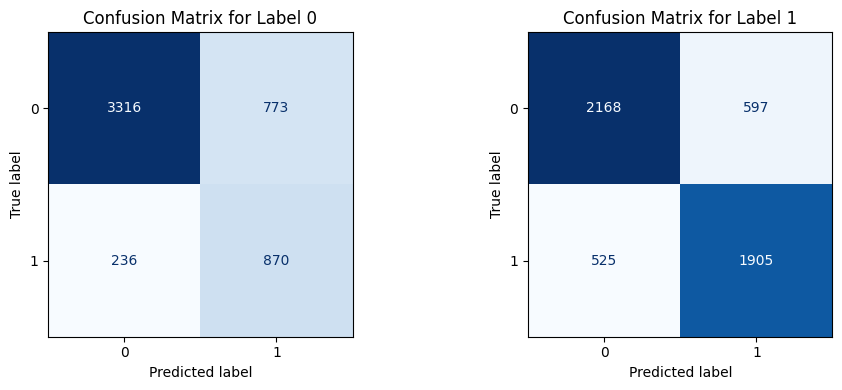

In [6]:
best_model = joblib.load("../Modelos/Prueba_Jaime/LogisticRegression_bayes_balanced.pkl")
print("TEST:")
print(evaluate_model(best_model, X_test, y_test))

# matriz de confusion
y_pred = best_model.predict(X_test)
fig, axes = plt.subplots(1, y_test.shape[1], figsize=(10, 4), dpi=100)
for i in range(y_test.shape[1]):
    cm = confusion_matrix(y_test.iloc[:, i], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(ax=axes[i], cmap='Blues', colorbar=False)  
    axes[i].set_title(f'Confusion Matrix for Label {i}')
plt.tight_layout()
plt.show()


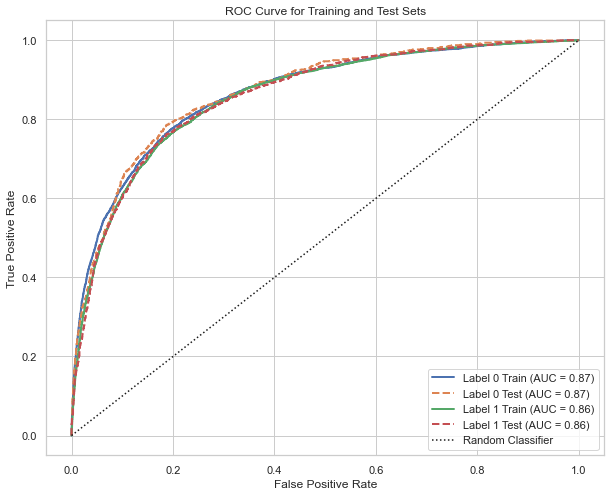

In [76]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

# Get probabilities for both train and test sets
y_train_proba = best_model.predict_proba(X_train)
y_test_proba = best_model.predict_proba(X_test)

# Plot ROC curves
plt.figure(figsize=(10, 8))

for i in range(y_test.shape[1]):  # Loop through each label
    # ROC for train and test sets
    fpr_train, tpr_train, _ = roc_curve(y_train.iloc[:, i], y_train_proba[i][:, 1])
    fpr_test, tpr_test, _ = roc_curve(y_test.iloc[:, i], y_test_proba[i][:, 1])

    # Plot both curves
    plt.plot(fpr_train, tpr_train, lw=2, label=f'Label {i} Train (AUC = {roc_auc_score(y_train.iloc[:, i], y_train_proba[i][:, 1]):.2f})')
    plt.plot(fpr_test, tpr_test, lw=2, linestyle='--', label=f'Label {i} Test (AUC = {roc_auc_score(y_test.iloc[:, i], y_test_proba[i][:, 1]):.2f})')

# Plot random classifier line
plt.plot([0, 1], [0, 1], 'k:', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Training and Test Sets')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## Coeficientes examinados

In [77]:
X_train.shape 

(20739, 96)

In [78]:
# Get the list of logistic regression models from the MultiOutputClassifier
log_reg_models = best_model

# For each model (for each label), print the coefficients with feature names
for i, model in enumerate(log_reg_models.estimators_):  # Access the estimators_ attribute
    print(f"Coefficients for label {i}:")
    
    # Pair coefficients with feature names
    coef_names = list(zip(X_train.columns, model.coef_[0]))  # Assumes a binary classification per label (coef_ is 2D, [0] to get the array)
    
    # Sort coefficients by the absolute value (optional, for better viewing)
    coef_names_sorted = sorted(coef_names, key=lambda x: abs(x[1]), reverse=True)
    
    # Print coefficients along with their feature names
    for feature, coef in coef_names_sorted:
        print(f"{feature}: {coef:.4f}")
    
    print("\n")



Coefficients for label 0:
doctor_recc_h1n1: 2.0463
employment_industry_haxffmxo: 1.2547
employment_occupation_dcjcmpih: 1.2547
health_insurance_Missing: -0.8166
health_worker: 0.7391
health_insurance: 0.7094
doctor_recc_seasonal: -0.5511
opinion_h1n1_vacc_effective: 0.5397
opinion_h1n1_risk: 0.4097
employment_industry_arjwrbjb: 0.3089
race_Black: -0.2919
employment_occupation_uqqtjvyb: -0.2840
child_under_6_months: 0.2839
employment_occupation_qxajmpny: -0.2626
employment_industry_atmlpfrs: -0.2457
employment_industry_mcubkhph: -0.2453
employment_occupation_hfxkjkmi: -0.2436
employment_industry_fcxhlnwr: 0.2384
sex: -0.2338
employment_industry_wxleyezf: 0.2218
employment_occupation_hodpvpew: 0.2156
employment_occupation_tfqavkke: -0.2086
behavioral_antiviral_meds: 0.1916
employment_occupation_Missing: 0.1782
employment_occupation_dlvbwzss: 0.1724
behavioral_face_mask: 0.1702
employment_occupation_xgwztkwe: -0.1685
rent_or_own: -0.1679
hhs_geo_region_dqpwygqj: -0.1519
employment_occupat

Coefficients for label 0:


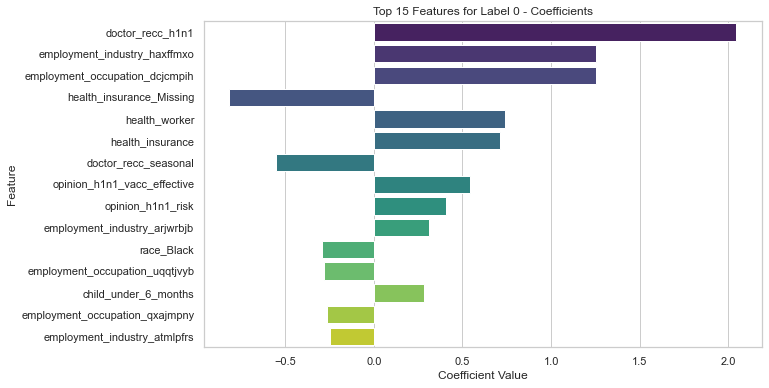



Coefficients for label 1:


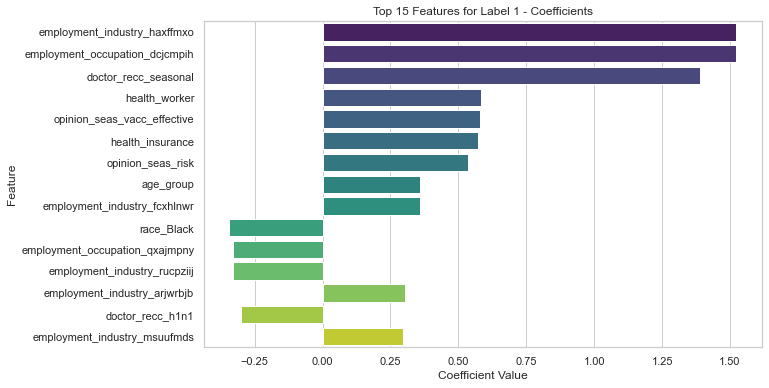

In [79]:
sns.set(style="whitegrid")

# For each model (for each label), print the coefficients and create a barplot
for i, model in enumerate(log_reg_models.estimators_):  # Access the estimators_ attribute
    print(f"Coefficients for label {i}:")
    
    # Pair coefficients with feature names
    coef_names = list(zip(X_train.columns, model.coef_[0]))  # Assumes binary classification per label (coef_ is 2D, [0] to get the array)
    
    # Sort coefficients by the absolute value (optional, for better viewing)
    coef_names_sorted = sorted(coef_names, key=lambda x: abs(x[1]), reverse=True)
    
    # Create a barplot of the top 15 coefficients
    top_15_features = coef_names_sorted[:15]
    features, coefs = zip(*top_15_features)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(coefs), y=list(features), hue=features, palette="viridis", legend=False)  # Set hue as features
    plt.title(f"Top 15 Features for Label {i} - Coefficients")
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.show()

    print("\n")



# Scaler 

Como prueba, la búsqueda se aplica también sobre los datos escalados. Lo que se ha observado a lo largo de todas las pruebas es que los resultados siguen siendo iguales en términos de rendimiento, pero las regresiones logísticas convergen siempre, y mucho más rápido.

In [62]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_test_scaled

array([[0.25      , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.66666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.5       , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.25      , 0.33333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.75      , 0.66666667, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.25      , 0.33333333, 0.        , ..., 0.        , 1.        ,
        0.        ]])

# Modelo sin regularización, con GridSearch y balanceo

In [52]:
# Con balanceo
# Envolver modelo de regresion en MultiOutputClassifier
logistic_regression_multilabel = MultiOutputClassifier(
    LogisticRegression(max_iter=1000, class_weight='balanced')
)

# Ajustar parámetros Grid Search para MultiOutputClassifier (sin regularización)
param_grid = {
    'estimator__solver': ['saga', 'lbfgs'],  # Compatible con penalty='none'
    'estimator__penalty': [None],  # Sin regularización
    'estimator__max_iter': [500, 1000, 2000],  
    'estimator__fit_intercept': [True, False],  
    'estimator__tol': [1e-3, 1e-4, 1e-5]  
}

# Grid Search
grid_search = GridSearchCV(
    estimator=logistic_regression_multilabel,
    param_grid=param_grid,
    cv=5,  # Validación cruzada con 5 particiones
    scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc_ovr'},  # Métricas
    refit='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Entrenar el modelo con los datos de entrenamiento
grid_search.fit(X_train_scaled, y_train)

# Guardar resultados
results = pd.DataFrame(grid_search.cv_results_)
columns = [
    'mean_test_accuracy', 
    'mean_test_roc_auc', 
    'param_estimator__solver', 
    'param_estimator__penalty', 
    'param_estimator__max_iter', 
    'param_estimator__tol',
    'param_estimator__fit_intercept'
]

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(grid_search.best_estimator_, "../Modelos/Prueba_Jaime/Scaling/LogisticRegression_gridsearch_none.pkl")
print("Modelo guardado como 'LogisticRegression_gridsearch_none.pkl'")

# Guardar y ordenar resultados
results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Jaime/Scaling/logistic_gridsearch_none_results_table.csv', index=False)
results_table.sort_values(by=['mean_test_roc_auc', 'mean_test_accuracy'], ascending=[False, False]).head(5)


Fitting 5 folds for each of 36 candidates, totalling 180 fits
Mejores hiperparámetros: {'estimator__fit_intercept': True, 'estimator__max_iter': 500, 'estimator__penalty': None, 'estimator__solver': 'lbfgs', 'estimator__tol': 0.001}
Modelo guardado como 'LogisticRegression_gridsearch_none.pkl'


,mean_test_accuracy,mean_test_roc_auc,param_estimator__solver,param_estimator__penalty,param_estimator__max_iter,param_estimator__tol,param_estimator__fit_intercept
3,0.642847,0.858398,lbfgs,None,500,0.0010,True
9,0.642847,0.858398,lbfgs,None,1000,0.0010,True
15,0.642847,0.858398,lbfgs,None,2000,0.0010,True
4,0.643763,0.858156,lbfgs,None,500,0.0001,True
10,0.643763,0.858156,lbfgs,None,1000,0.0001,True


In [54]:
best_model = joblib.load("../Modelos/Prueba_Jaime/Scaling/LogisticRegression_gridsearch_none.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train_scaled, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test_scaled, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.47505793 0.62349319 0.06867637 0.2147123  0.37370169]
Primeras 5 probabilities para label 1: [0.74290578 0.54087939 0.78759324 0.12612405 0.51882594] 

ROC AUC global: 0.7849671254080672
Accuracy global: 0.6478132986161339
ROC AUC Scores de cada label: [0.8654697027846827, 0.8584053616588093]
Accuracy Scores de cada label: [0.7961328897246733, 0.7825835382612469] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      4433
           1       0.76      0.78      0.77      9718

   micro avg       0.66      0.78      0.72     14151
   macro avg       0.64      0.77      0.69     14151
weighted avg       0.69      0.78      0.72     14151
 samples avg       0.36      0.38      0.36     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.03835104 0.78001688 0.20102351 0.32874751 0.

# GridSearch

In [65]:
# Con balanceo
# Envolver modelo de regresion en MultiOutputClassifier
logistic_regression_multilabel =  MultiOutputClassifier(LogisticRegression(max_iter=1000, class_weight='balanced'))

# Adjustar parametros Grid Search para MultiOutputClassifier
param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10, 100, 1000],  
    'estimator__penalty': ['l1', 'l2'],            
    'estimator__solver': ['liblinear', 'saga'],    
    'estimator__max_iter': [100, 1000]             
}

# Grid Search
grid_search = GridSearchCV(
    estimator=logistic_regression_multilabel,
    param_grid=param_grid,
    cv=5,  
    scoring={'accuracy': 'accuracy', 'roc_auc': 'roc_auc'}, 
    refit='roc_auc',  
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)
grid_search.fit(X_train_scaled, y_train)


# Guardar resultados
results = pd.DataFrame(grid_search.cv_results_)
columns = [
    'mean_test_accuracy', 
    'mean_test_roc_auc', 
    'param_estimator__C', 
    'param_estimator__penalty', 
    'param_estimator__solver', 
    'param_estimator__max_iter'
]
# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", grid_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(grid_search.best_estimator_, "../Modelos/Prueba_Jaime/Scaling/LogisitcRegression_gridsearch_balanced.pkl")
print("Modelo guardado como 'LogisitcRegression_gridsearch_balanced.pkl'")

results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Jaime/Scaling/logistic_gridsearch_balanced_results_table.csv', index=False)
results_table.sort_values(by=['mean_test_roc_auc', 'mean_test_accuracy'], ascending=[False, False]).head(5)


Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros: {'estimator__C': 0.1, 'estimator__max_iter': 1000, 'estimator__penalty': 'l1', 'estimator__solver': 'saga'}
Modelo guardado como 'LogisitcRegression_gridsearch_balanced.pkl'


,mean_test_accuracy,mean_test_roc_auc,param_estimator__C,param_estimator__penalty,param_estimator__solver,param_estimator__max_iter
13,0.645161,0.858394,0.1,l1,saga,1000
9,0.645161,0.858393,0.1,l1,saga,100
21,0.645113,0.858363,1.0,l1,saga,1000
17,0.645113,0.858363,1.0,l1,saga,100
20,0.645017,0.858358,1.0,l1,liblinear,1000


In [66]:
best_model = joblib.load("../Modelos/Prueba_Jaime/Scaling/LogisitcRegression_gridsearch_balanced.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train_scaled, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test_scaled, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.47444835 0.59743903 0.07674084 0.22486887 0.38482301]
Primeras 5 probabilities para label 1: [0.74619163 0.567223   0.76819548 0.1195996  0.51400522] 

ROC AUC global: 0.7851682447816598
Accuracy global: 0.649500940257486
ROC AUC Scores de cada label: [0.8648348917080394, 0.8577282599502879]
Accuracy Scores de cada label: [0.7980616230290757, 0.7825835382612469] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      4433
           1       0.76      0.77      0.77      9718

   micro avg       0.67      0.77      0.72     14151
   macro avg       0.64      0.77      0.69     14151
weighted avg       0.69      0.77      0.72     14151
 samples avg       0.36      0.38      0.36     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.03540547 0.78417138 0.25100235 0.35909589 0.4

# Bayes Search

In [67]:
# Envolver el modelo de regresión en MultiOutputClassifier
logistic_regression_multilabel = MultiOutputClassifier(LogisticRegression(max_iter=5000, class_weight='balanced'))

# Definir el espacio de búsqueda de hiperparámetros
param_space = {
    'estimator__C': (1e-6, 1e+6, 'log-uniform'),  
    'estimator__penalty': ['l1', 'l2'],           
    'estimator__solver': ['liblinear', 'saga']            
}

# Bayesian Optimization con BayesSearchCV
bayes_search = BayesSearchCV(
    estimator=logistic_regression_multilabel,
    search_spaces=param_space,
    n_iter=50, 
    cv=5,  
    scoring='roc_auc', 
    refit=True, 
    n_jobs=-1,
    return_train_score=True
)
bayes_search.fit(X_train_scaled, y_train)

# Mostrar los mejores hiperparámetros
print("Mejores hiperparámetros:", bayes_search.best_params_)

# Guardar el mejor modelo optimizado
joblib.dump(bayes_search.best_estimator_, "../Modelos/Prueba_Jaime/Scaling/LogisticRegression_bayes_balanced.pkl")
print("Modelo guardado como 'LogisticRegression_bayes_balanced.pkl'")

# Guardar los resultados de la búsqueda
results = pd.DataFrame(bayes_search.cv_results_)
columns = [
    'mean_test_score', 
    'param_estimator__C', 
    'param_estimator__penalty', 
    'param_estimator__solver'
]
results_table = results[columns].copy()
results_table.to_csv('../Results/Prueba_Jaime/Scaling/logistic_bayes_balanced_results_table.csv', index=False)

# Ordenar los resultados por ROC AUC
results_table.sort_values(by='mean_test_score', ascending=False).head(5)


C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 'l1', 'saga'] before, using random point [2.563491353175967e-05, 'l2', 'saga']
  warnings.warn(
C:\Users\RUXI\AppData\Local\Programs\Python\Python310\lib\site-packages\skopt\optimizer\optimizer.py:517: UserWarning: The objective has been evaluated at point [1000000.0, 'l1', 'saga'] before, using random point [0.5970243639051798, 'l1', 'liblinear']
  warnings.warn(


Mejores hiperparámetros: OrderedDict([('estimator__C', 0.5970243639051798), ('estimator__penalty', 'l1'), ('estimator__solver', 'liblinear')])
Modelo guardado como 'LogisticRegression_bayes_balanced.pkl'


,mean_test_score,param_estimator__C,param_estimator__penalty,param_estimator__solver
23,0.858464,0.597024,l1,liblinear
6,0.858432,0.729601,l1,saga
27,0.858343,0.097098,l2,saga
42,0.858338,0.413033,l2,saga
43,0.858333,0.427269,l2,saga


In [69]:
best_model = joblib.load("../Modelos/Prueba_Jaime/Scaling/LogisticRegression_bayes_balanced.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train_scaled, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test_scaled, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.46917185 0.57517682 0.07474319 0.21583123 0.38409508]
Primeras 5 probabilities para label 1: [0.74084131 0.54456621 0.77782826 0.12129139 0.52650864] 

ROC AUC global: 0.786369281426194
Accuracy global: 0.6501759969140267
ROC AUC Scores de cada label: [0.8657295786988795, 0.8586365243072128]
Accuracy Scores de cada label: [0.798302714692126, 0.7835479049134481] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      4433
           1       0.77      0.78      0.77      9718

   micro avg       0.67      0.78      0.72     14151
   macro avg       0.64      0.78      0.70     14151
weighted avg       0.69      0.78      0.72     14151
 samples avg       0.36      0.38      0.36     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.04056001 0.78325806 0.2083293  0.3477989  0.44

# Optuna

In [55]:
def objective(trial):
    # Define the hyperparameters to tune
    C = trial.suggest_float('C', 1e-6, 1e+6, log=True)
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    solver = trial.suggest_categorical('solver', ['liblinear', 'saga'])
    max_iter = 5000
    
    # Create the logistic regression model
    logistic = LogisticRegression(
        max_iter=max_iter,
        C=C,
        penalty=penalty,
        solver=solver,
        class_weight='balanced',
        random_state=42
    )
    model = MultiOutputClassifier(logistic)
    
    # Perform cross-validation using the in-built roc_auc_score for multilabel
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring="roc_auc")
    return scores.mean()


# Optimizar con Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)


[I 2025-01-23 17:08:54,888] A new study created in memory with name: no-name-cb5efd4d-570c-415c-9a83-4423e061b512
[I 2025-01-23 17:08:55,196] Trial 0 finished with value: 0.5 and parameters: {'C': 0.0001497873592401863, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 0 with value: 0.5.
[I 2025-01-23 17:09:08,198] Trial 1 finished with value: 0.8581162917286458 and parameters: {'C': 122567.34752876329, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 1 with value: 0.8581162917286458.
[I 2025-01-23 17:09:08,763] Trial 2 finished with value: 0.8102159791361652 and parameters: {'C': 0.0033524507951991963, 'penalty': 'l1', 'solver': 'liblinear'}. Best is trial 1 with value: 0.8581162917286458.
[I 2025-01-23 17:09:09,104] Trial 3 finished with value: 0.5 and parameters: {'C': 6.955494949341281e-05, 'penalty': 'l1', 'solver': 'saga'}. Best is trial 1 with value: 0.8581162917286458.
[I 2025-01-23 17:09:12,468] Trial 4 finished with value: 0.8055934187969133 and parameters: {'C': 0.0017

In [56]:
# Reconstruir el mejor modelo
best_params = study.best_params
print("Mejores hiperparámetros:", best_params)
logistic = LogisticRegression(
    C=best_params['C'],
    penalty=best_params['penalty'],
    solver=best_params['solver'],
    class_weight='balanced',
    max_iter = 5000
)
best_model = MultiOutputClassifier(logistic)
best_model.fit(X_train_scaled, y_train)

# Guardar modelo
joblib.dump(best_model, "../Modelos/Prueba_Jaime/Scaling/LogisticRegression_optuna_balanced.pkl")
print("Modelo guardado como 'LogisticRegression_optuna_balanced.pkl'")


Mejores hiperparámetros: {'C': 0.27417237838541564, 'penalty': 'l2', 'solver': 'liblinear'}
Modelo guardado como 'LogisticRegression_optuna_balanced.pkl'


In [63]:
# Cargar el mejor modelo optimizado por Optuna
best_model = joblib.load("../Modelos/Prueba_Jaime/Scaling/LogisticRegression_optuna_balanced.pkl")
print("TRAIN:")
print(evaluate_model(best_model, X_train_scaled, y_train))

print("TEST:")
print(evaluate_model(best_model, X_test_scaled, y_test))

TRAIN:
Primeras 5 probabilities para label 0: [0.46134641 0.58733796 0.07935531 0.21796609 0.37684314]
Primeras 5 probabilities para label 1: [0.73383023 0.54764094 0.77282856 0.12537328 0.53982624] 

ROC AUC global: 0.7860854191335923
Accuracy global: 0.6496938135879261
ROC AUC Scores de cada label: [0.8657041237251174, 0.8585809511557749]
Accuracy Scores de cada label: [0.7981098413616857, 0.7831621582525676] 

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.52      0.77      0.62      4433
           1       0.76      0.78      0.77      9718

   micro avg       0.67      0.78      0.72     14151
   macro avg       0.64      0.78      0.70     14151
weighted avg       0.69      0.78      0.72     14151
 samples avg       0.36      0.38      0.36     14151

-----------------------------------------------------------------------------------
TEST:
Primeras 5 probabilities para label 0: [0.04513068 0.77715637 0.20683767 0.34110147 0.

# Grafico de las métricas para los modelos sin escalar

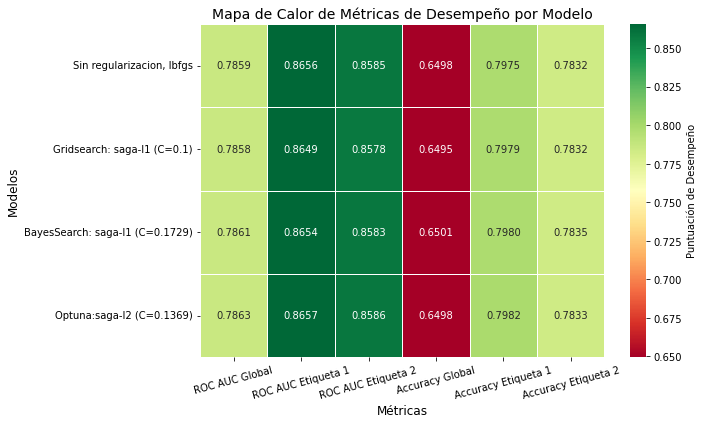

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Datos
modelos = ['Gridsearch: lbfgs sin regularización', 'Gridsearch: saga-l1 (C=0.1)', 'BayesSearch: saga-l1 (C=0.1729)', 'Optuna:saga-l2 (C=0.1369)']
metricas = [
    'ROC AUC Global', 'ROC AUC Etiqueta 1', 'ROC AUC Etiqueta 2',
    'Accuracy Global', 'Accuracy Etiqueta 1', 'Accuracy Etiqueta 2'
]
datos = [
    [0.7859, 0.8656, 0.8585, 0.6498, 0.7975, 0.7832],
    [0.7858, 0.8649, 0.8578, 0.6495, 0.7979, 0.7832],
    [0.7861, 0.8654, 0.8583, 0.6501, 0.7980, 0.7835],
    [0.7863, 0.8657, 0.8586, 0.6498, 0.7982, 0.7833]
]

# Crear un DataFrame
df = pd.DataFrame(datos, index=modelos, columns=metricas)

# Graficar heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, annot=True, cmap='RdYlGn', fmt=".4f", cbar=True, linewidths=0.5,
            cbar_kws={'label': 'Puntuación de Desempeño'})

# Etiquetas y título
plt.title('Mapa de Calor de Métricas de Desempeño por Modelo', fontsize=14)
plt.xlabel('Métricas', fontsize=12)
plt.ylabel('Modelos', fontsize=12)
plt.xticks(rotation=15)
plt.tight_layout()

# Mostrar gráfica
plt.show()

